<a href="https://colab.research.google.com/github/kamnsv/colab/blob/main/Task5_%7C_%D0%A6%D0%9F%D0%90_%7C_%D0%9E%D0%A0%D0%A2%D0%9F%D0%A0_%7C_%D0%9A%D0%B0%D0%BC%D0%BD%D0%B5%D0%B2_%D0%A1%D0%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Определить тенденцию при наливе и сливе содержимого резервуара по реальным данным.


# Решение

1. В разделе Датасет происходит загрузка данных с гугл диск из формата csv.

Данные формируются в единую таблицу с заголвками

Дата-время (Dt) | Метровая отметка (Lvl) | Номер резервуара (Rez)

2. В выборках по параметрам формируется X и Y, где X состоит из 

step_in_the_last кол-ва изменений уровня. Изменения уровня конвентируется в булевые значения, где 1 это залив, 0 - слив. Последнее значение помещается в Y.

3. Нейронная сеть обучается на X ( в обучении не фигурирует время отметок).

Сеть предсказывает направление тенденции изменения уровня.

In [ ]:
#@title Импорт библиотек
import requests                 # библиотека запросов
import gdown                    # Работа с облаком
import os                       # Работы с ОС
import time                     # Замер времени
import datetime                 # Работа с даиами
import pandas as pd             # Работа с таблицами
import matplotlib.pyplot as plt # Отрисовка графиков
import seaborn as sns           # Работа с графиками
sns.set_style('darkgrid') 
import numpy as np              # Работа с массивами
from IPython.display import display, clear_output # Работа с дисплеем вывода
# Библиотеки для работы с нейроной сетью
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.preprocessing   import StandardScaler # номализация
from tensorflow.keras.models import Sequential # Модель нейронной сети
from tensorflow.keras.utils import plot_model # архитектура модели
from tensorflow.keras.optimizers import Adam # градиентный спуск
from tensorflow.keras.callbacks import Callback # колбэки для обучения
# Подлкючаем модуль TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
# Слои нейронной сети
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, RepeatVector
import warnings
warnings.filterwarnings("ignore")

## Датасет

In [ ]:
#@title Загрузка архива
print('Загрузка архива с Google storage...') 
file_id   = '1zmCTVz0O9ZX22S-Jx-fuWX93gCyalHwC'
file_url  = 'https://drive.google.com/uc?id='+file_id
file_name = 'task5.zip'
gdown.download(file_url, file_name, quiet=False) # Скачивание файла

Загрузка архива с Google storage...


Downloading...
From: https://drive.google.com/uc?id=1zmCTVz0O9ZX22S-Jx-fuWX93gCyalHwC
To: /content/task5.zip
13.8MB [00:00, 153MB/s]


'task5.zip'

In [ ]:
#@title Распаковка архива
!rm -R /content/task5 # Проверяем наличие папки texts. Если есть, удаляем ее
!unzip -q '/content/task5.zip' -d /content/task5

rm: cannot remove '/content/task5': No such file or directory


In [ ]:
#@title Загрузка данных
folder = '/content/task5'
df = pd.DataFrame()
for i in os.listdir(folder):
  st = time.time()
  print('Загрузка '+i+'...')
  data = pd.read_csv(folder+'/'+i, sep=';',
                     names=['Dt', 'Lvl'], 
                     dtype={'Lvl':np.float64},
                     parse_dates=['Dt'])
  print('Загружено {} строк за {:.2f} сек.\n'.
        format(len(data), time.time()-st))
  data['Rez'] = int(i.split('.')[0])
  if 0 == len(df):
    df = data
  else:
    df = pd.concat([df, data])
df # обзор

Загрузка 32.csv...
Загружено 184963 строк за 2.04 сек.

Загрузка 31.csv...
Загружено 171062 строк за 1.86 сек.

Загрузка 27.csv...
Загружено 177474 строк за 1.92 сек.

Загрузка 37.csv...
Загружено 155152 строк за 1.60 сек.

Загрузка 28.csv...
Загружено 844 строк за 0.00 сек.

Загрузка 22.csv...
Загружено 182121 строк за 1.91 сек.

Загрузка 40.csv...
Загружено 10174 строк за 0.10 сек.

Загрузка 26.csv...
Загружено 187745 строк за 1.97 сек.

Загрузка 36.csv...
Загружено 111211 строк за 1.08 сек.

Загрузка 16.csv...
Загружено 209155 строк за 23.59 сек.

Загрузка 35.csv...
Загружено 51055 строк за 0.50 сек.

Загрузка 19.csv...
Загружено 3025 строк за 0.00 сек.



,Dt,Lvl,Rez
0,2020-07-27 12:28:50.390286+03:00,4004.000000,32
1,2020-07-27 12:29:08.631537+03:00,4003.000000,32
2,2020-07-27 12:29:27.887643+03:00,4002.000000,32
3,2020-07-27 12:30:04.509482+03:00,4001.000000,32
4,2020-07-27 12:30:22.773074+03:00,4000.000000,32
...,...,...,...
3020,2020-11-01 21:51:25.594000,6119.000000,19
3021,2020-11-01 21:51:28.262000,6117.999512,19
3022,2020-11-01 21:51:33.659000,6119.000000,19
3023,2020-11-01 21:51:37.201000,6117.999512,19


## Парсинг и анализ

In [ ]:
#@title Пустые ячейки
print('Строки с пустыми значением уровня', df.Lvl.isna().sum())
df = df[df.Lvl.notna()]
print('Строк стало', len(df))
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df # обзор

Строки с пустыми значением уровня 35
Строк стало 1443946


,Dt,Lvl,Rez
0,2020-07-27 12:28:50.390286+03:00,4004.000000,32
1,2020-07-27 12:29:08.631537+03:00,4003.000000,32
2,2020-07-27 12:29:27.887643+03:00,4002.000000,32
3,2020-07-27 12:30:04.509482+03:00,4001.000000,32
4,2020-07-27 12:30:22.773074+03:00,4000.000000,32
...,...,...,...
1443941,2020-11-01 21:51:25.594000,6119.000000,19
1443942,2020-11-01 21:51:28.262000,6117.999512,19
1443943,2020-11-01 21:51:33.659000,6119.000000,19
1443944,2020-11-01 21:51:37.201000,6117.999512,19


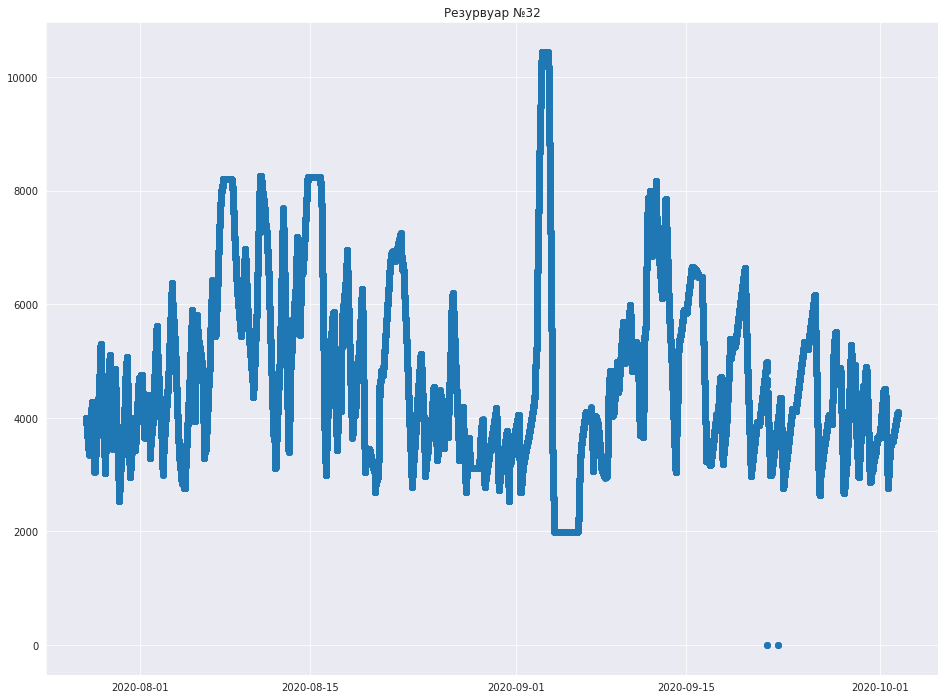

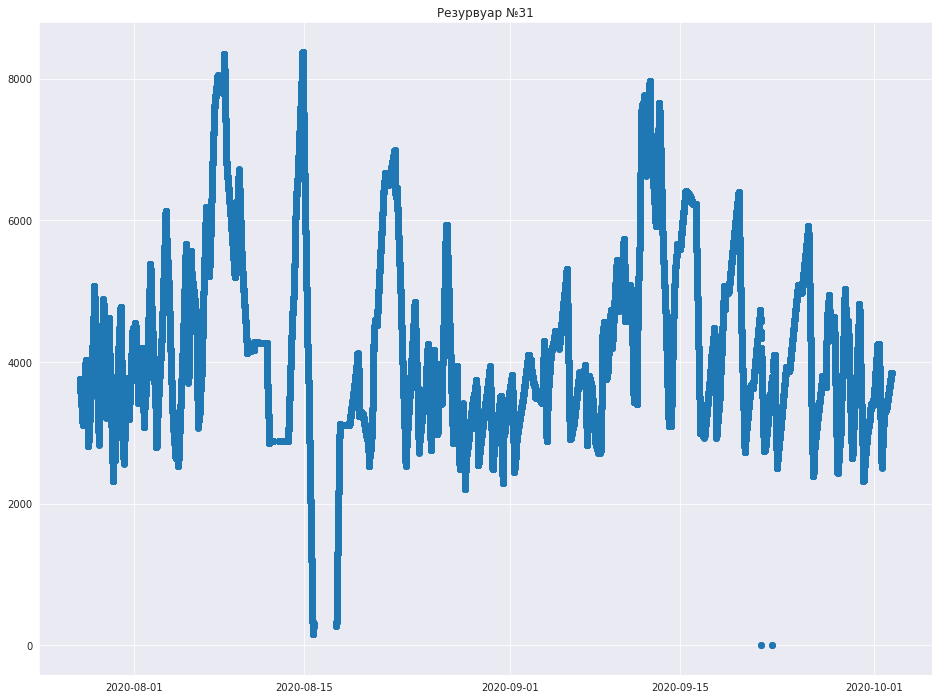

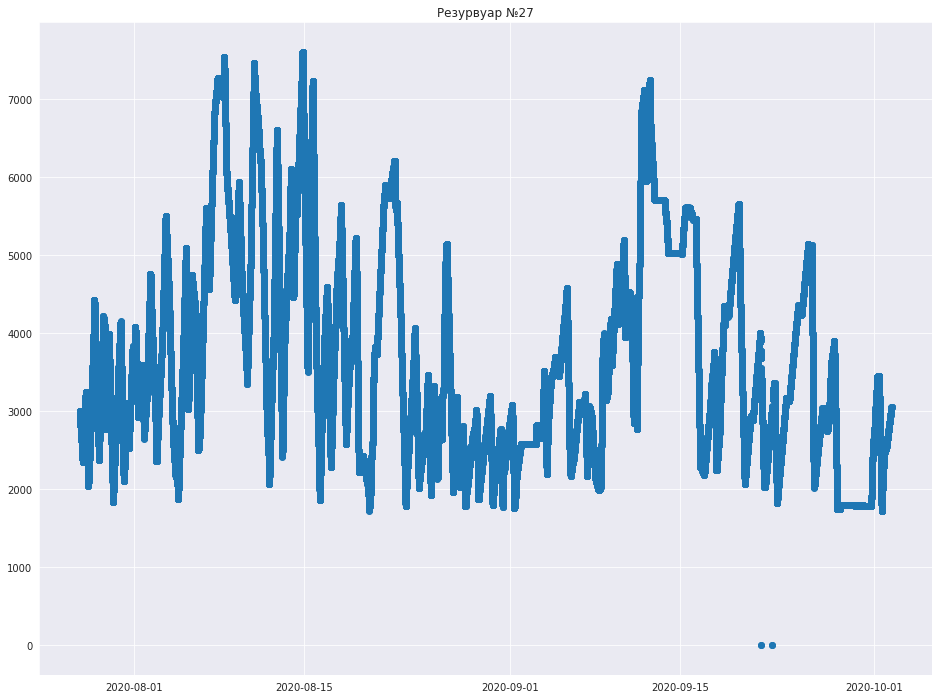

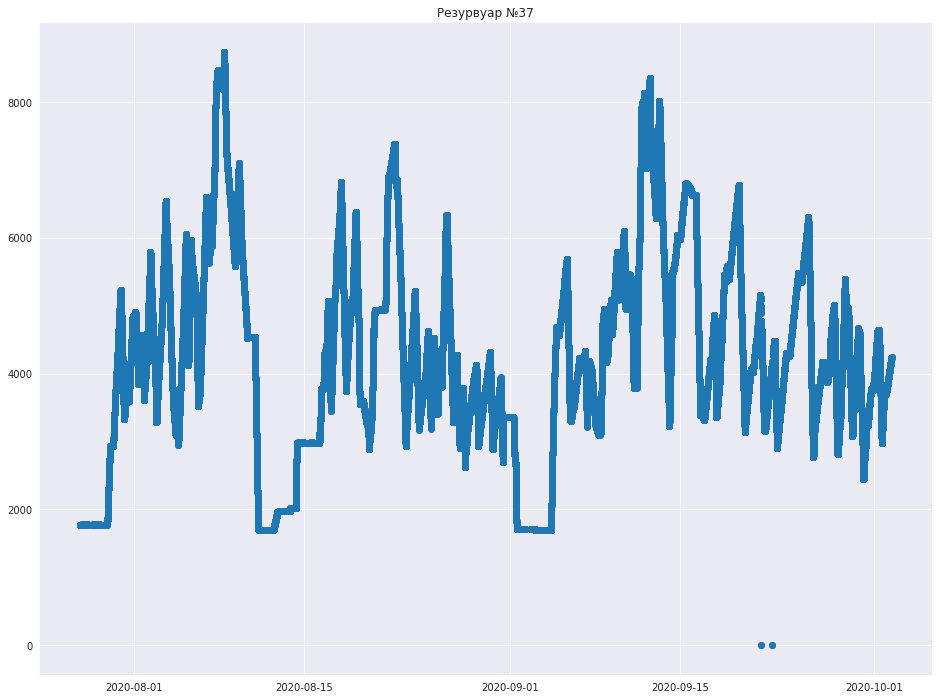

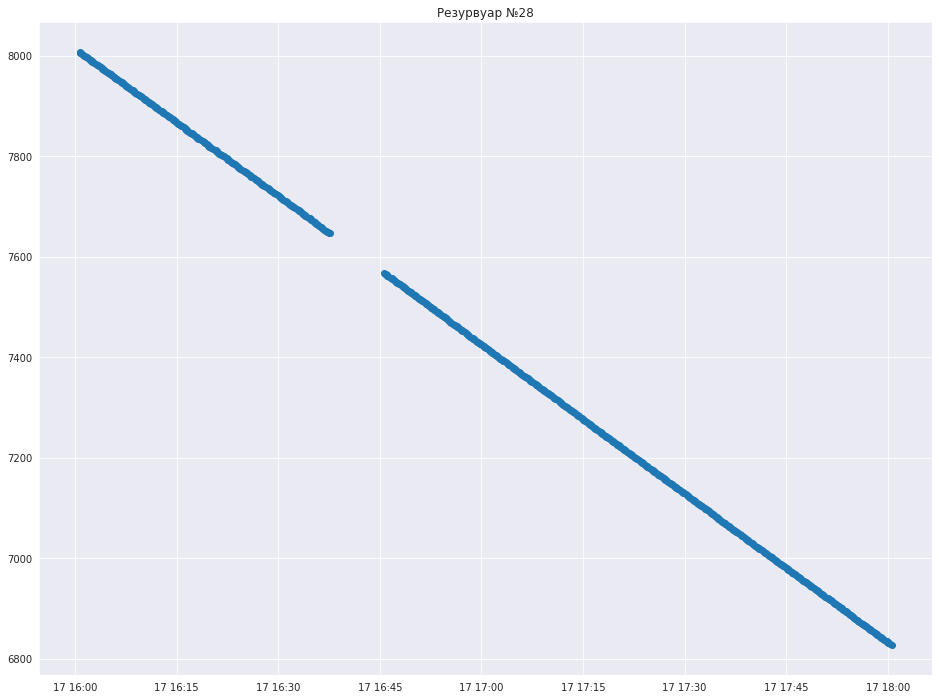

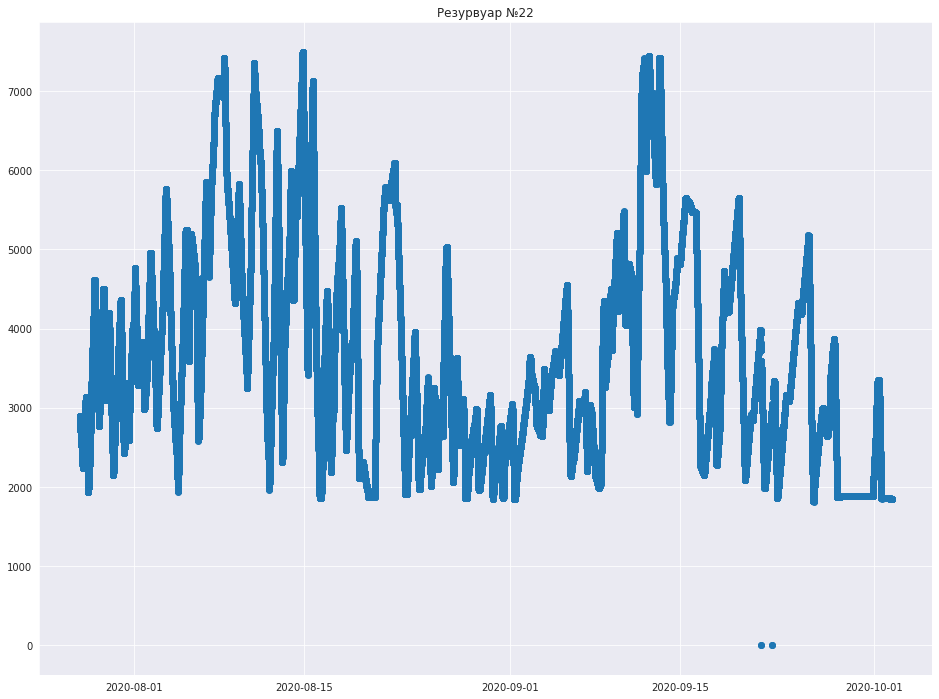

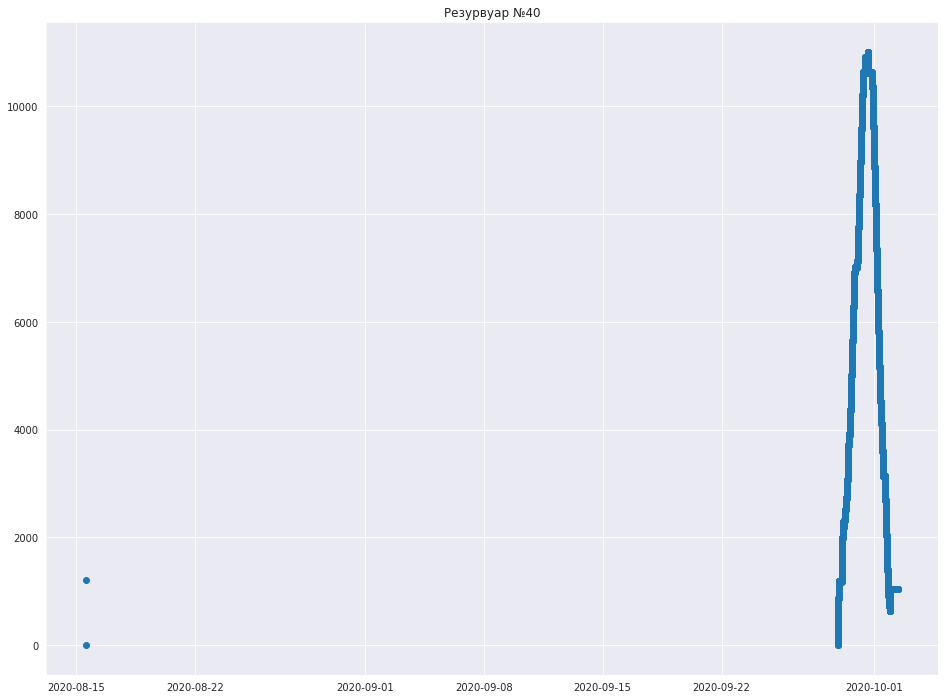

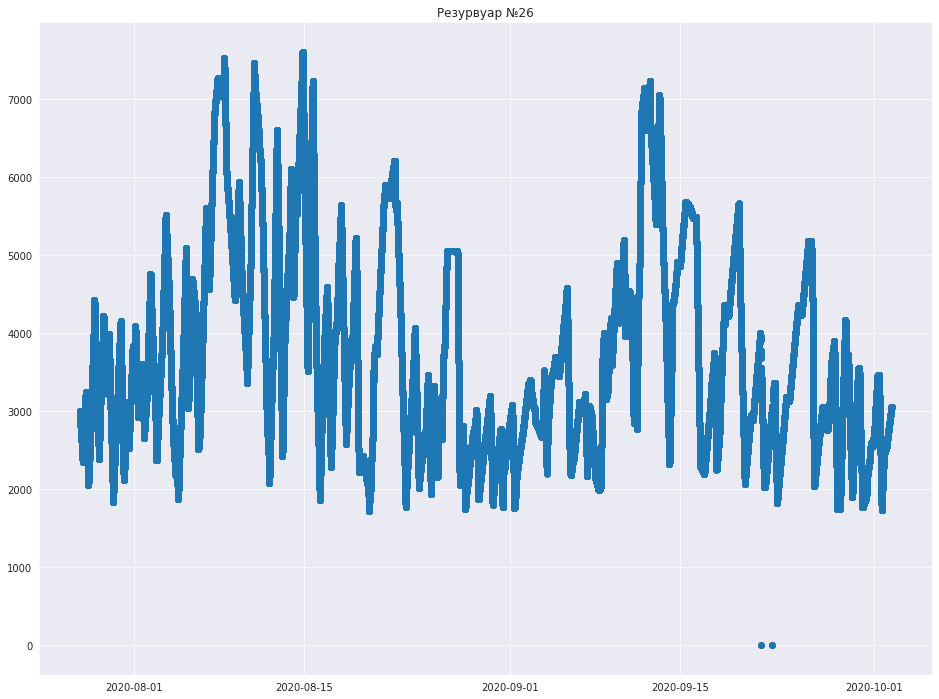

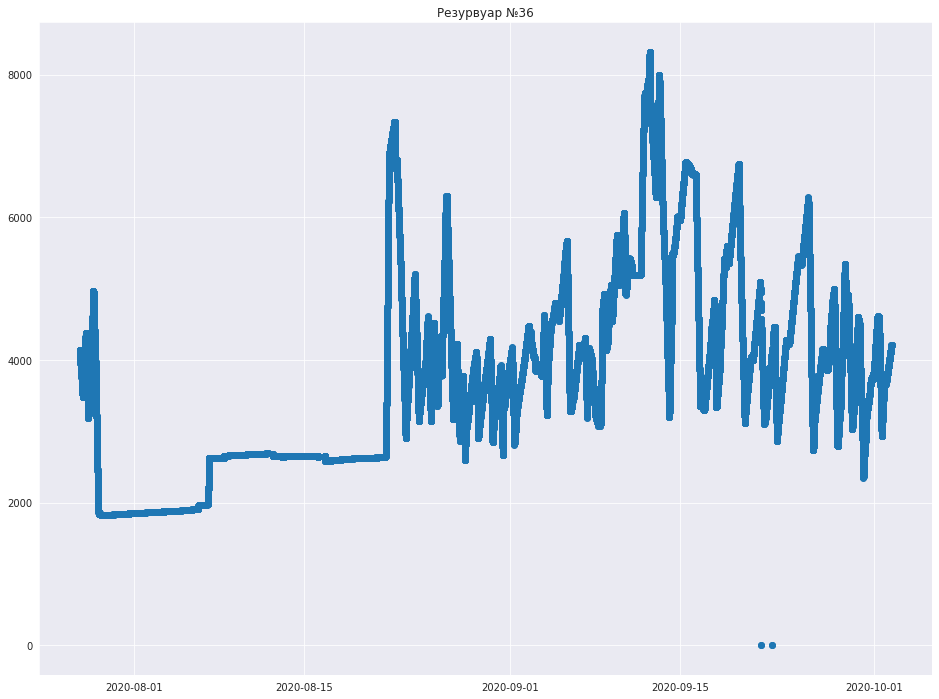

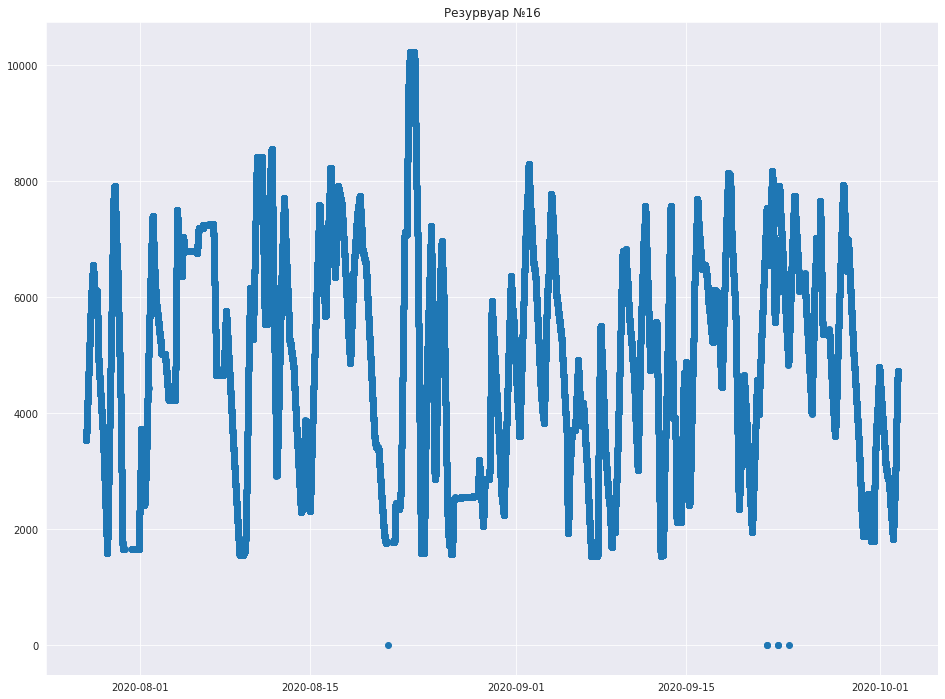

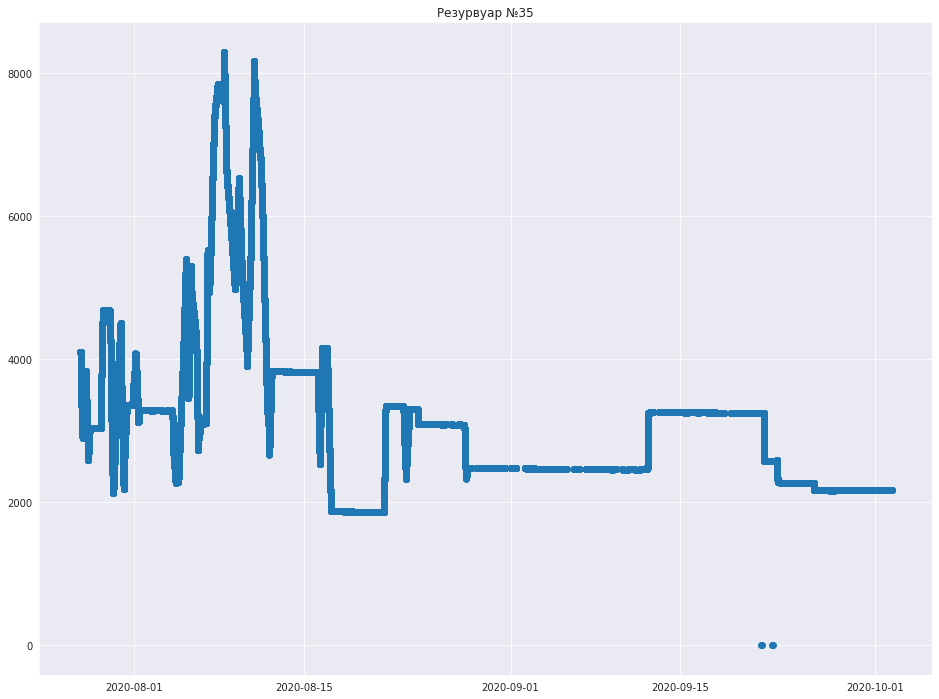

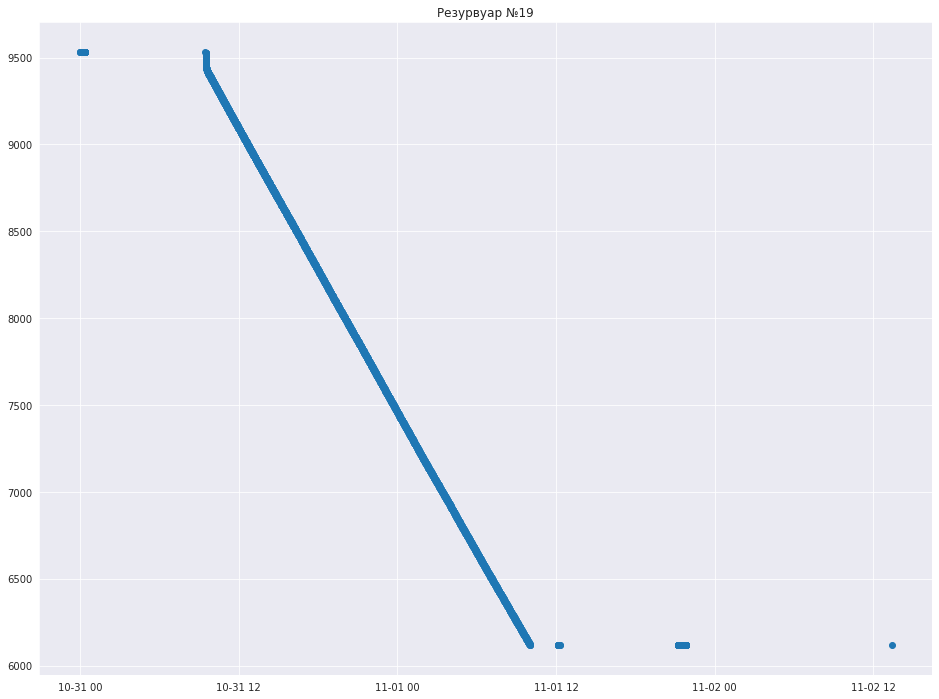

In [ ]:
#@title Точечные графики
for i in df.Rez.unique():
  data = df[df.Rez==i]
  plt.figure(figsize=(16, 12))
  plt.title('Резурвуар №'+str(i))
  plt.scatter(data.Dt, data.Lvl)
  plt.show()

## Выборки

In [ ]:
#@title Параметры
#@markdown #### По скольки шагам в прошлое определяем тренд
step_in_the_last = 14 #@param {type:"slider", min: 4, max: 20, step: 1}
#@markdown #### Серию из скольки строк анализируем
n_steps = 20          #@param {type:"slider", min: 6, max: 48, step: 1}
#@markdown #### Размер тестовая выборки от общей
test_split = 0.2 #@param {type:"slider", min: 0.1, max: 0.9, step: 0.01}


In [ ]:
#@title Вычеты
# считаем относительную доходность единицах на step_in_the_last шагов назад
data = df[df.Rez==16].copy()
for i in range(1, step_in_the_last + 1):
  indicator_name = 'chng_%d' % (i)
  data[indicator_name] = data['Lvl'].pct_change(i) # относительная доходность единицах
print(data.shape)
data[:5]

(209123, 17)


,Dt,Lvl,Rez,chng_1,chng_2,chng_3,chng_4,chng_5,chng_6,chng_7,chng_8,chng_9,chng_10,chng_11,chng_12,chng_13,chng_14
1180746,2020-07-27 12:28:50.381316+03:00,3530.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180747,2020-07-27 12:29:08.628581+03:00,3531.0,16,0.000283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180748,2020-07-27 12:29:27.884636+03:00,3532.0,16,0.000283,0.000567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180749,2020-07-27 12:29:46.270095+03:00,3533.0,16,0.000283,0.000566,0.00085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180750,2020-07-27 12:30:04.506527+03:00,3534.0,16,0.000283,0.000566,0.00085,0.001133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data.dropna() # удаляем строки с NaN
print(data.shape)
data[:5]

(209109, 17)


,Dt,Lvl,Rez,chng_1,chng_2,chng_3,chng_4,chng_5,chng_6,chng_7,chng_8,chng_9,chng_10,chng_11,chng_12,chng_13,chng_14
1180760,2020-07-27 12:33:27.077621+03:00,3545.0,16,0.000282,0.000564,0.000847,0.001130,0.001412,0.001695,0.001979,0.002545,0.002829,0.003113,0.003397,0.003681,0.003965,0.004249
1180761,2020-07-27 12:33:45.317372+03:00,3546.0,16,0.000282,0.000564,0.000847,0.001129,0.001412,0.001695,0.001978,0.002261,0.002828,0.003112,0.003396,0.003680,0.003964,0.004248
1180762,2020-07-27 12:34:03.553552+03:00,3547.0,16,0.000282,0.000564,0.000847,0.001129,0.001412,0.001694,0.001977,0.002261,0.002544,0.003111,0.003395,0.003679,0.003963,0.004247
1180763,2020-07-27 12:34:21.798257+03:00,3548.0,16,0.000282,0.000564,0.000846,0.001129,0.001411,0.001694,0.001977,0.002260,0.002543,0.002826,0.003394,0.003678,0.003962,0.004246
1180764,2020-07-27 12:34:40.055846+03:00,3549.0,16,0.000282,0.000564,0.000846,0.001128,0.001411,0.001693,0.001976,0.002259,0.002542,0.002826,0.003109,0.003676,0.003960,0.004244


In [ ]:
#@title Разметка тренда
# Добавил разметку направления тренда
for i in range(1, step_in_the_last + 1):
  indicator_name = 'chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data[indicator_name_new] = 0
  data.loc[data[indicator_name] > 0 , indicator_name_new] = 1

for i in range(1, step_in_the_last + 1):
  indicator_name = 'chng_%d' % (i)
  del data[indicator_name]

del data['Rez']

print(data.shape)
data[:5]

(209109, 16)


,Dt,Lvl,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
1180760,2020-07-27 12:33:27.077621+03:00,3545.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1180761,2020-07-27 12:33:45.317372+03:00,3546.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1180762,2020-07-27 12:34:03.553552+03:00,3547.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1180763,2020-07-27 12:34:21.798257+03:00,3548.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1180764,2020-07-27 12:34:40.055846+03:00,3549.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
#@title Общая выборка
indicator_name = 'Y_%d' % (step_in_the_last)
Y = np.array(data[indicator_name])
X = data.drop(columns=['Dt', indicator_name]).values
print(X.shape, type(X))
print(Y.shape, type(Y))

(209109, 14) <class 'numpy.ndarray'>
(209109,) <class 'numpy.ndarray'>


In [ ]:
#@title Обучающая и тестовая
n_train = int(len(X)*(1-test_split)) 
x_train = X[:n_train-n_steps]
x_test  = X[n_train+n_steps:]
y_train = Y[:n_train-n_steps]
y_test  = Y[n_train+n_steps:]

print('xTrain: ', x_train.shape, '\tyTrain:', y_train.shape,
      '\nxTest:  ', x_test.shape, '\tyTest: ', y_test.shape)

xTrain:  (167267, 14) 	yTrain: (167267,) 
xTest:   (41802, 14) 	yTest:  (41802,)


In [ ]:
#@title Нормализация
x_scaler = StandardScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
print(x_train.shape, x_test.shape, type(x_train))
x_test[-1:]

(167267, 14) (41802, 14) <class 'numpy.ndarray'>


array([[-0.14864576,  1.0723239 ,  1.10524989,  1.08247994,  1.10426266,
         1.08431821,  1.10331644,  1.0845662 ,  1.10209179,  1.08481425,
         1.10097505,  1.08482731,  1.09983312,  1.08499707]])

In [ ]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# n_steps = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, n_steps, forvard_lag):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # проверяем, чтобы не выйти за пределы массива
      break 
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return np.array(X), np.array(y)

In [ ]:
#@title Формирование выборок
X_test, Y_test   = split_sequence(x_test, y_test, n_steps, forvard_lag=1)
X_train, Y_train = split_sequence(x_train, y_train, n_steps, forvard_lag=1)

In [ ]:
X_train.shape, Y_train.shape

((167247, 20, 14), (167247,))

## Нейронная сеть

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 20, 40)            2840      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 40)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 400)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 20)             40020     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 20)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40)               

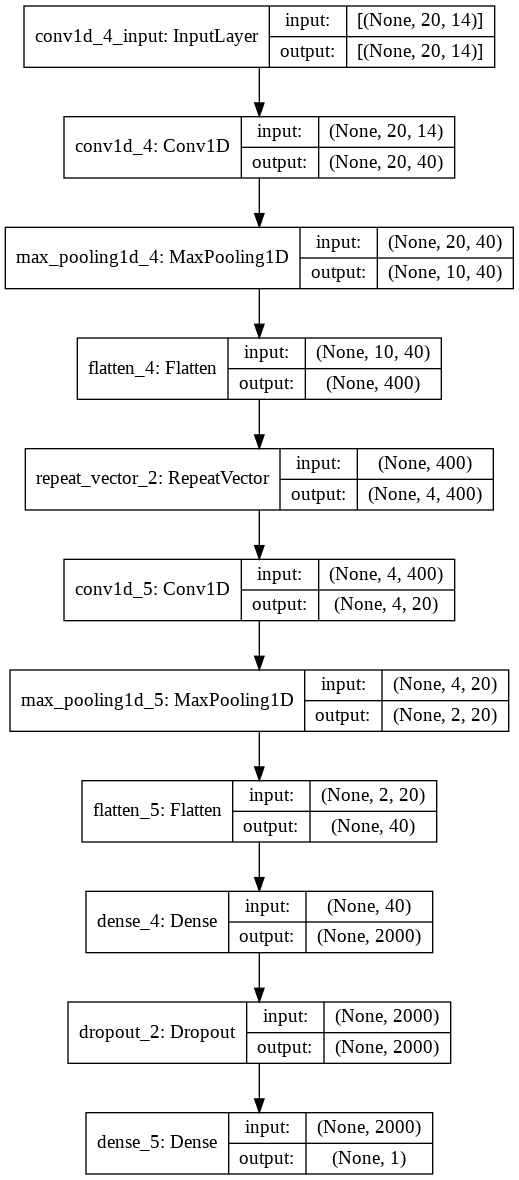

In [ ]:
#@title Модель
model = Sequential([
  Conv1D(n_steps*2, 5, padding='same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPool1D(pool_size=2),
  Flatten(),
  RepeatVector(4),
  Conv1D(n_steps, 5, padding='same', activation='relu'),
  MaxPool1D(pool_size=2),
  Flatten(),
  Dense(n_steps*100, activation='relu'),
  Dropout(0.3),
  Dense(1, activation='sigmoid')
])
print(model.summary())
plot_model(model, dpi=96, show_shapes=True) # Выводим схему модели

In [ ]:
#@title Параметры обучения
#@markdown #### Скорость обучния
lr = "0.0001" #@param [0.1, 0.01, 0.001, 0.0001, 0.00001] 
#@markdown #### Кол-во эпох
epochs = 50 #@param {type:"slider", min:1, max:10000, step:10}
#@markdown #### Размер проверочной от оьучающей
valid_split = 0.2 #@param {type:"slider", min: 0.1, max: 0.9, step: 0.01}
#@markdown #### Размер батча
batch_size = 32 #@param {type:"slider", min: 16, max: 512, step: 8}

In [ ]:
#@title Колбэки
class ComputeMetrics(Callback):
    def on_epoch_end(self, epoch, logs):
      global all_time, start_time, loss_min
      clear_output(wait=True) # очистка
      acc_cur = logs['accuracy']
      val_acc_cur = logs['val_accuracy']
      acc.append(logs['accuracy'])
      val_acc.append(logs['val_accuracy'])
      loss.append(logs['loss'])
      val_loss.append(logs['val_loss'])
      fig, ax = plt.subplots(2, 2, figsize=(16, 12))
      ax[0,0].text(0, 1,'Результат эпохи №'+str(epoch+1), fontsize = font_size)
    #1. Тексты
      ax[0,0].set_yticklabels([])
      ax[0,0].set_xticklabels([])
      ax[0,0].axis('off')
      ax[0,0].text(0, 0.9, 'Текущая точность: {:.5f}/{:.5f}'.
                   format(acc_cur, val_acc_cur), fontsize = font_size)
    #2. График accuracy по всем эпохам на обучающей и проверочная выборках
      ax[1,0].set_title('График точности обучения')
      ax[1,0].plot(acc,     label='Обучаущая выборка')  
      ax[1,0].plot(val_acc, label='Проверочная выборка')
      ax[1,0].legend()
      ax[1,0].set_xlabel('Эпоха обучения')
      ax[1,0].set_ylabel('Точность')     
    #3. График ошибок по всем эпохам на обучающей и проверочная выборках
      ax[1,1].set_title('График ошибок')
      ax[1,1].plot(loss,     label='Обучаущая выборка')  
      ax[1,1].plot(val_loss, label='Проверочная выборка')
      ax[1,1].set_xlabel('Обучаущая выборка')
      ax[1,1].set_ylabel('Проверочная выборка')
    #4. Разброс ошибки
      ax[0,1].set_title('Разброс ошибок')
      ax[0,1].scatter(loss, val_loss)
      ax[0,1].set_xlabel('Обучаущая выборка')
      ax[0,1].set_ylabel('Проверочная выборка')
      ax[0,1].axis('equal')
    #5. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
      all_time = np.append(all_time, time.time() - start_time)
      ax[0,0].text(0, 0.8, 'Время обучения на эпохе: {:.2f} c.'. 
                    format(all_time[-1]), fontsize = font_size)
      sec = all_time.sum()
      if sec > 60: sec = str(round(sec/60,2)) + ' м.' 
      else: sec = str(round(sec,2)) + ' c.' 
      ax[0,0].text(0,0.7,'Суммарное время обучения: '+sec,fontsize = font_size)
      sec = (epochs-epoch)*all_time.mean()
      if sec > 60: sec = str(round(sec/60,2)) + ' м.' 
      else: sec = str(round(sec,2)) + ' c.' 
      ax[0,0].text(0,0.6,'Примерно осталось времени: '+sec,fontsize = font_size) 
    #6. Сохраняет в .h5 сеть с лучшей точностью
      if -1 == loss_min or loss_min > val_acc_cur:
        model.save_weights('model_best.h5')
        loss_min = val_acc_cur
      # Вывод 
      plt.show()
      start_time = time.time() # Замер времени обучения


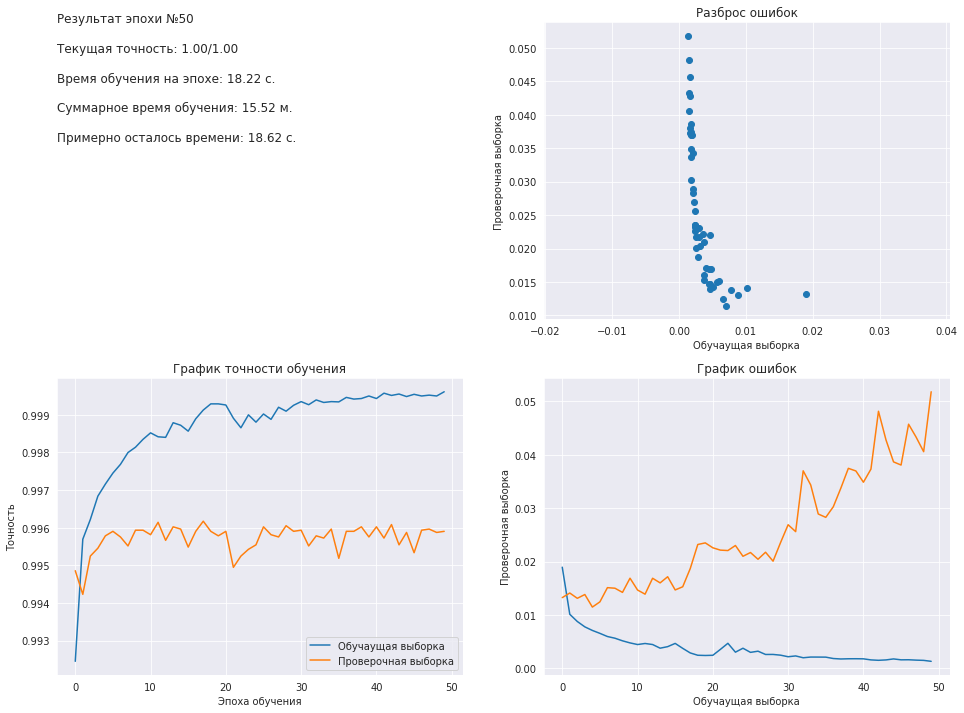

In [ ]:
#@title Обучение

loss_min = -1
val_mae_all = []
mae_all_org = []
val_mae_all_org = []
start_time = time.time() # Замер времени обучения
all_time = np.array([])
font_size = 12
loss, val_loss = [], []
acc, val_acc = [], []
# Компиляция
model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=float(lr)), 
                metrics=['accuracy'])
# Обучение
h = model.fit(X_train, Y_train, verbose = 1, epochs = epochs,
                       batch_size = batch_size, shuffle = False,
                       validation_split = valid_split,
                       callbacks = [ComputeMetrics()])

In [ ]:
#@title Проверка на тестовой
model.load_weights('model_best.h5')
"""
true_answer = 0
print('Тестирование на', len(Y_test), 'векторах')
for i, x in enumerate(X_train):
  x = np.expand_dims(x, axis=0)
  pred = model.predict(x)
  if pred[0][0] - Y_test[i] == 0:
    true_answer+=1
print('Правильных ответов:', true_answer)
print('Процент:', 100*true_answer/len(Y_test))

def check_model(x, y):
  pred = model.evaluate(x, y)
  print('Модель определяет напрвление тренда с точность {:.4f}%'.
        format(100*pred[1]))
  слив, налив, вибрации = [], [], []
  for i, p in enumerate(model.predict(x)):
    if float(p[0])>=0.7: налив.append(x) #'НАЛИВ'
    elif float(p[0])<=0.3: слив.append(x)  #'СЛИВ'
    else: вибрации.append(x)
  return слив, налив, вибрации

слив, налив, вибрации = check_model(X_test, Y_test)

"""
model.evaluate(X_test, Y_test)

1306/1306 [==============================] - 3s 2ms/step - loss: 0.0148 - accuracy: 0.9942


[0.014840665273368359, 0.9941840767860413]

In [ ]:
#@title Маркирование
def predict_one(ind): 
  clear_output(wait=True) # очистка
  # 0 - слив
  # 1 - налив
  # 2 - вибрации
  rez = df.loc[ind, 'Rez']
  #print(rez)
  data = df[(df.Rez==rez) & (df.index < ind)]
  if (len(data) < n_steps+step_in_the_last): 
    return None
  print('Резервуар №'+str(rez), 'строка', ind)  
  data = df[(df.Rez==rez) & (df.index < ind)]
  data = data[ind-n_steps-step_in_the_last:ind+1]
  # Вычеты
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    data[indicator_name] = data['Lvl'].pct_change(i)
  #print(data)
  # удаляем строки с NaN
  data = data.dropna()
  # Разметка тренда
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    indicator_name_new = 'Y_%d' % (i)
    data[indicator_name_new] = 0
    data.loc[data[indicator_name] > 0 , indicator_name_new] = 1
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    del data[indicator_name]
  del data['Rez']
  #print(data)
  # Формирование выборок
  indicator_name = 'Y_%d' % (step_in_the_last)
  x = data.drop(columns=['Dt', indicator_name]).values
  # Нормализация
  x = x_scaler.transform(x)
  #print(x)
  x = np.expand_dims(x, axis=0)
  # print(x.shape)
  p = float(model.predict(x)[0])
  if p>=0.7: return 1 #'НАЛИВ'
  if p<=0.3: return 0  #'СЛИВ'
  return 2 #'вибрации'


In [ ]:
def predict_column(rez): 
  data = df[df.Rez==rez]
  # Вычеты
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    data[indicator_name] = data['Lvl'].pct_change(i)
  # удаляем строки с NaN
  data = data.dropna()
  # Разметка тренда
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    indicator_name_new = 'Y_%d' % (i)
    data[indicator_name_new] = 0
    data.loc[data[indicator_name] > 0 , indicator_name_new] = 1
  for i in range(1, step_in_the_last + 1):
    indicator_name = 'chng_%d' % (i)
    del data[indicator_name]
  del data['Rez']
  # Формирование выборок
  indicator_name = 'Y_%d' % (step_in_the_last)
  y = np.array(data[indicator_name])
  x = data.drop(columns=['Dt', indicator_name]).values
  # Нормализация
  x = x_scaler.transform(x)
  # Создание наборов
  X, Y   = split_sequence(x, y, n_steps, forvard_lag=1)
  # Предсказание НС
  p = model.predict(X)
  # Интерпритация результатов
  for i, v in enumerate(p):
    if   v>=0.7:   p[i] = 1  #'НАЛИВ'
    elif v<=0.3:   p[i] = 0  #'СЛИВ'
    else:          p[i] = 2  #'вибрации'
  # Разница массива
  dif = df[df.Rez==rez].shape[0]-p.shape[0]
  p = np.append([None]*dif, p)
  return p

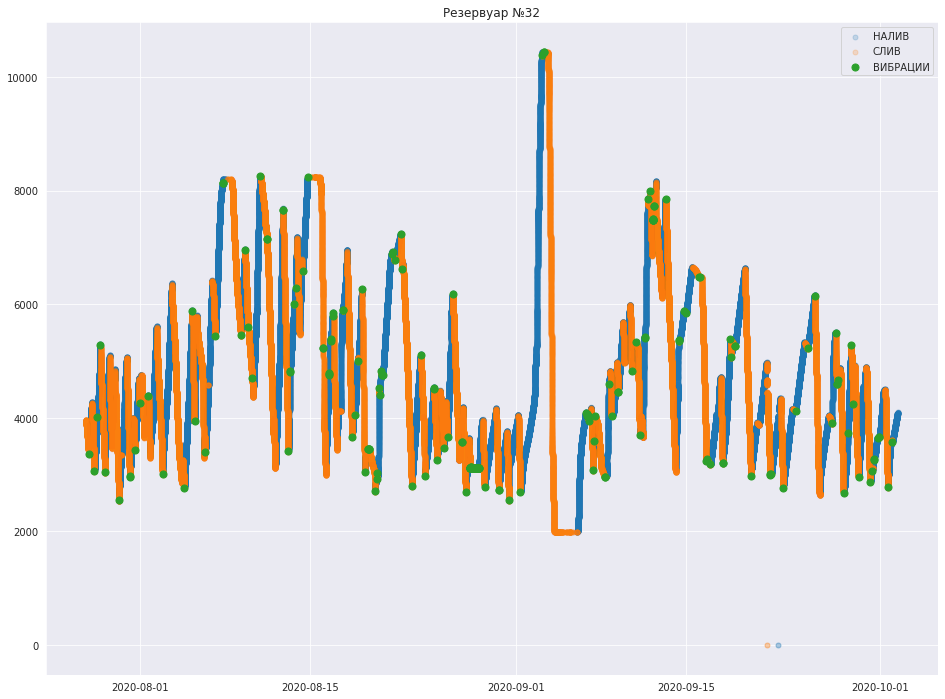

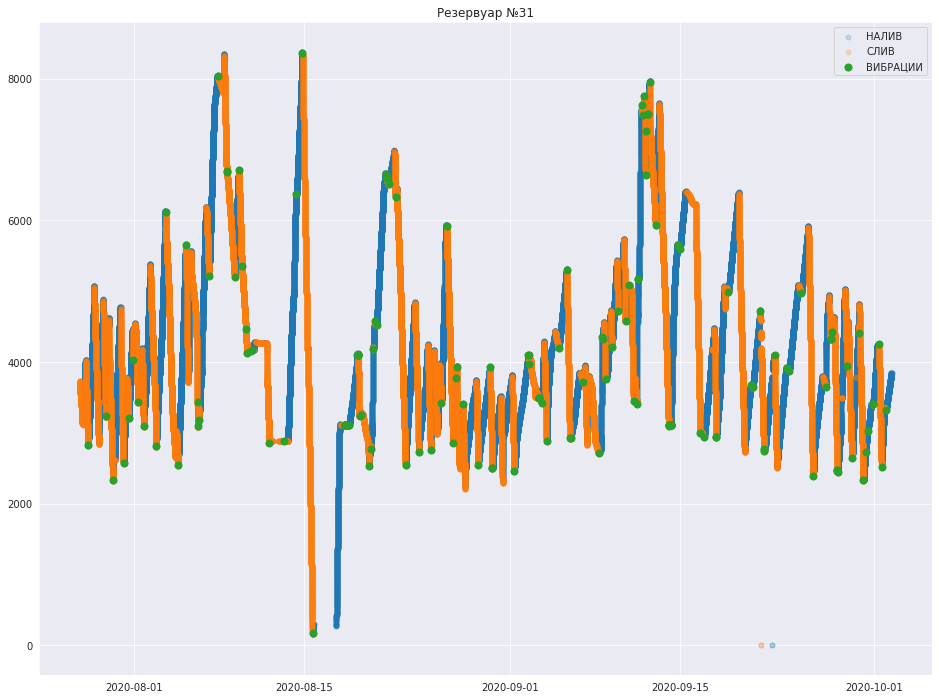

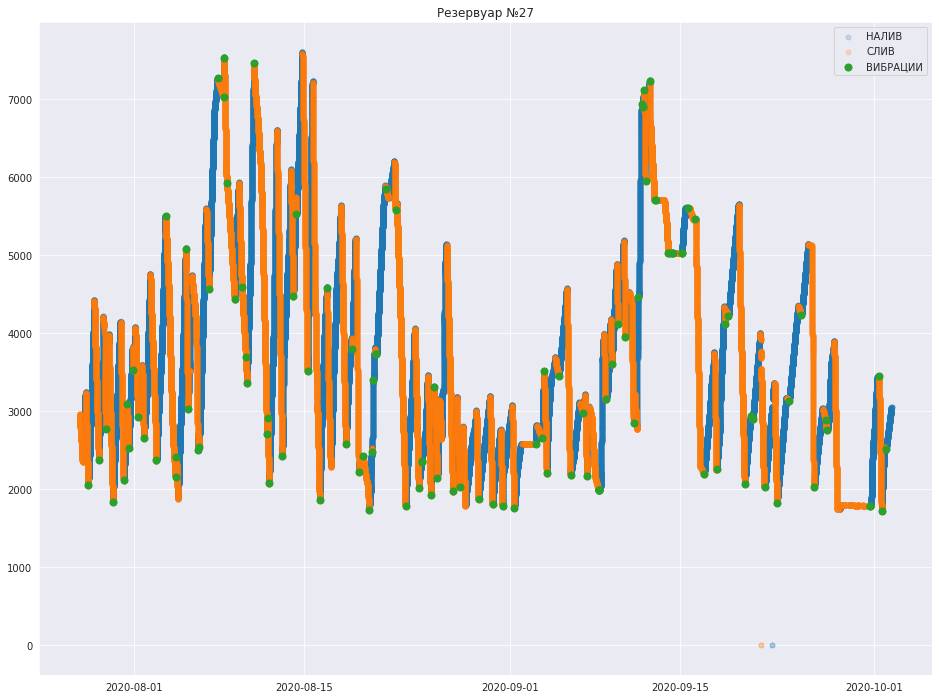

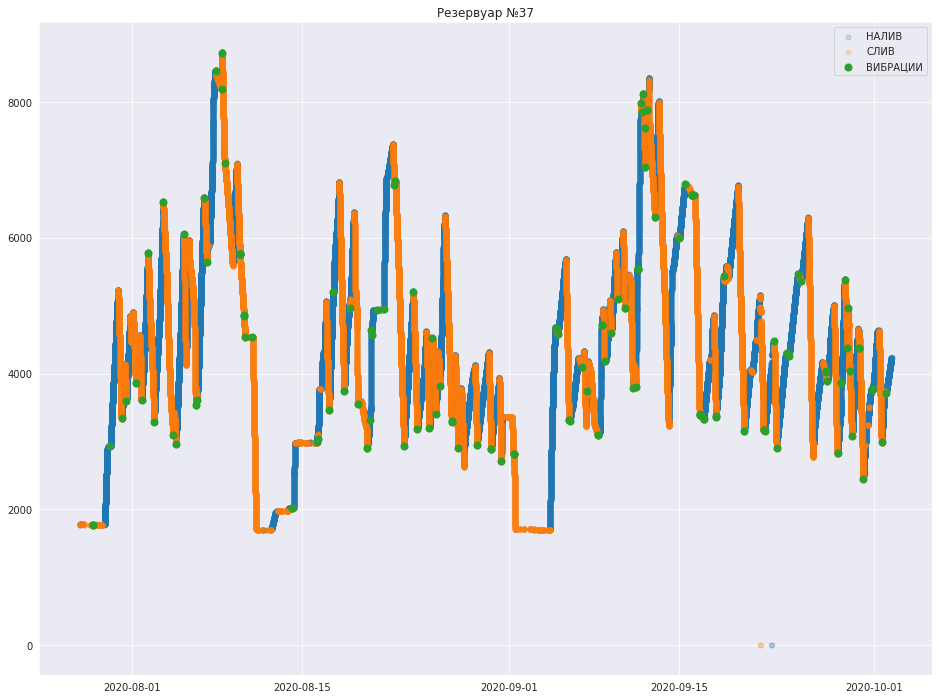

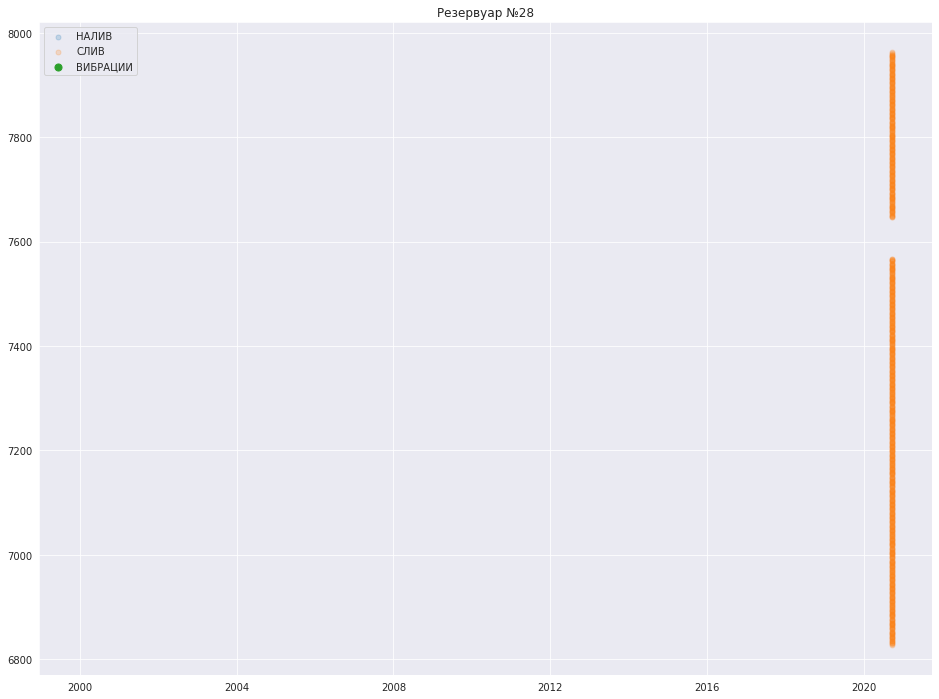

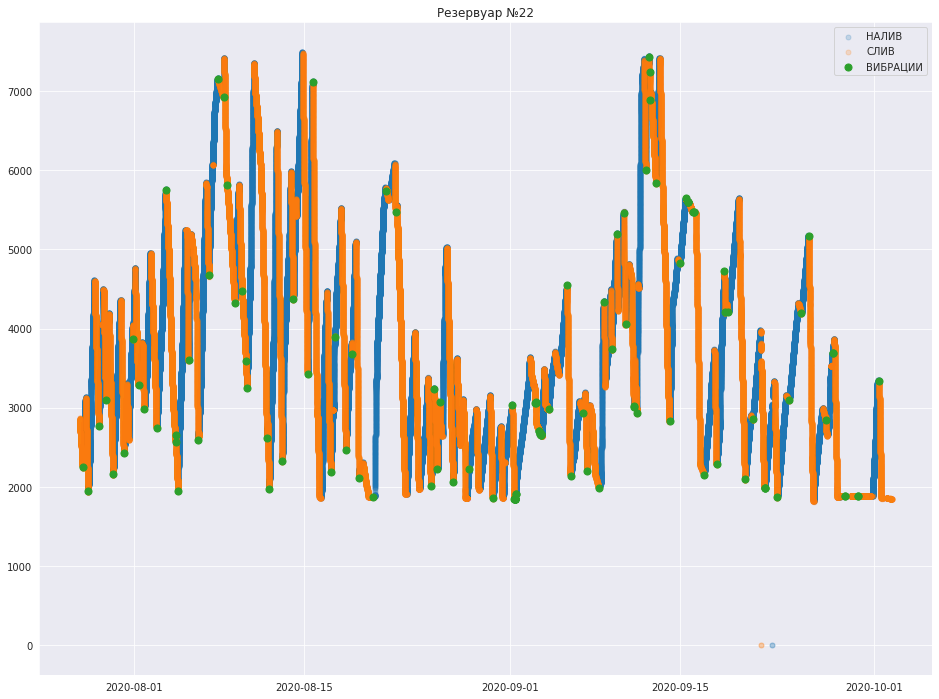

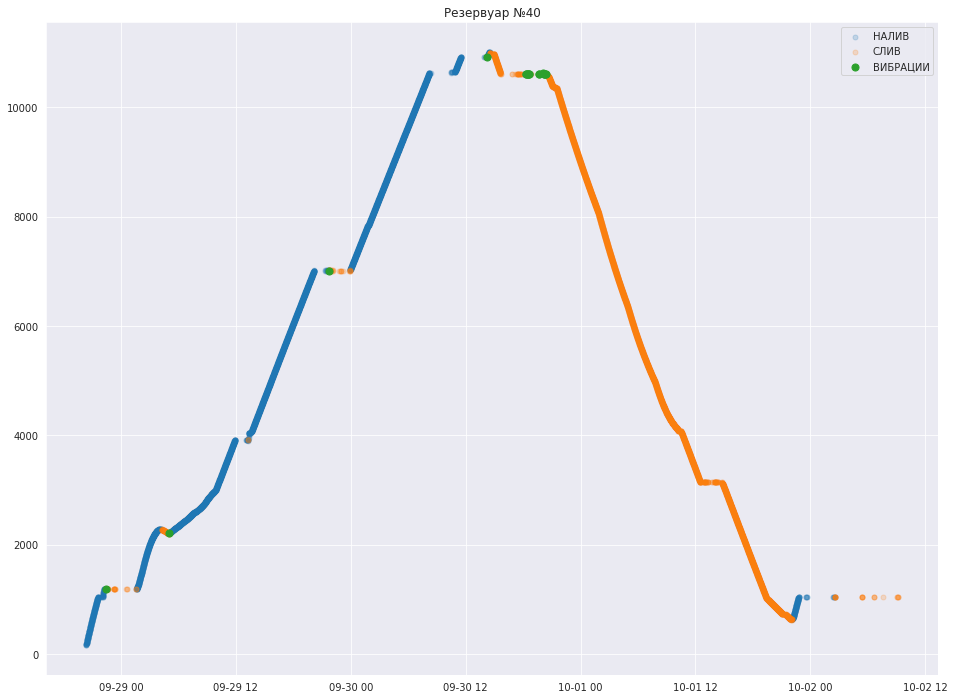

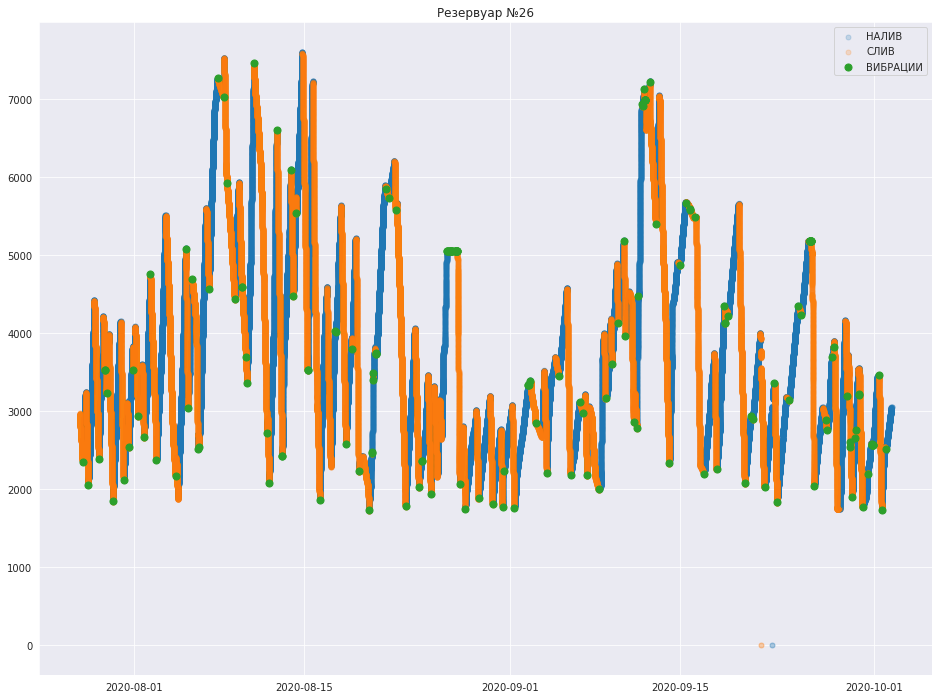

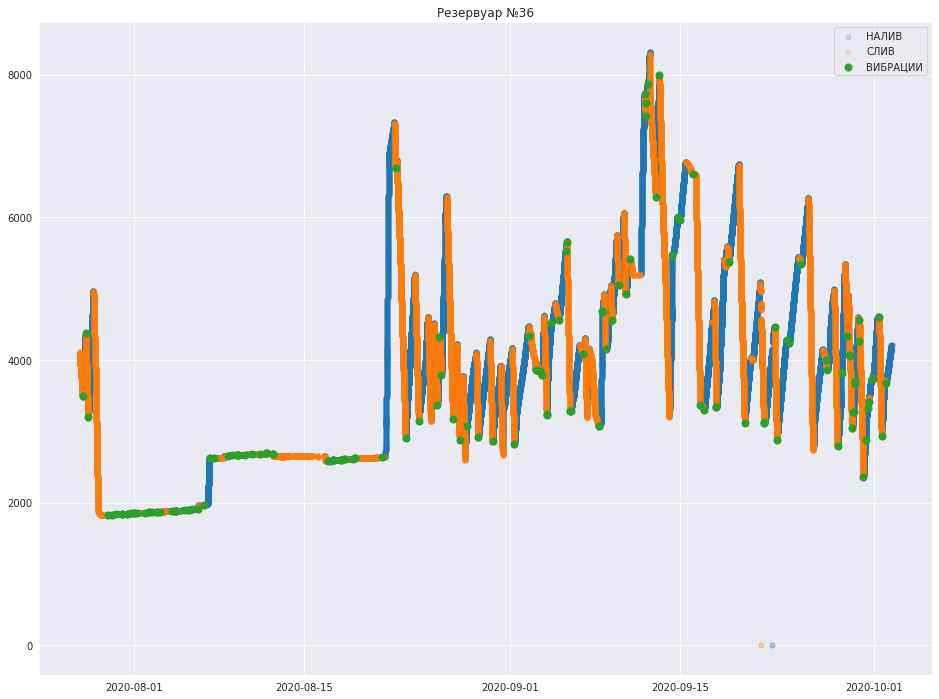

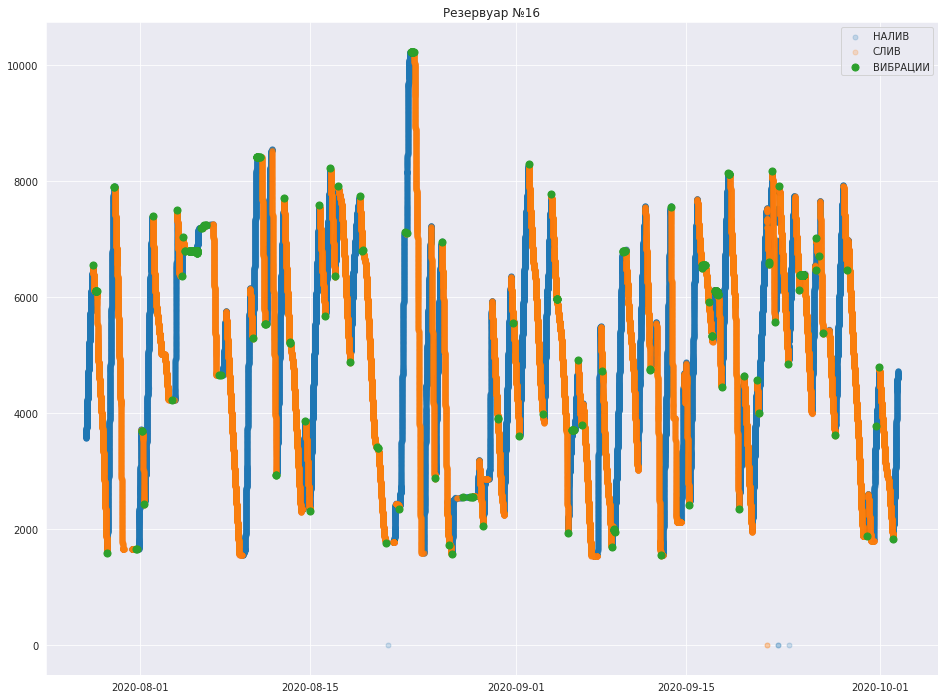

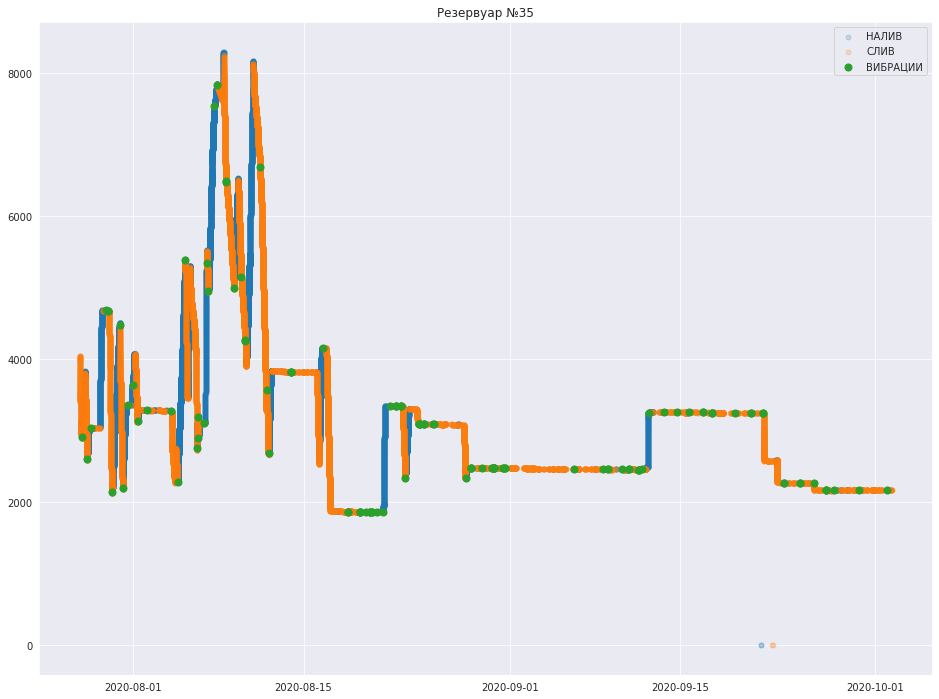

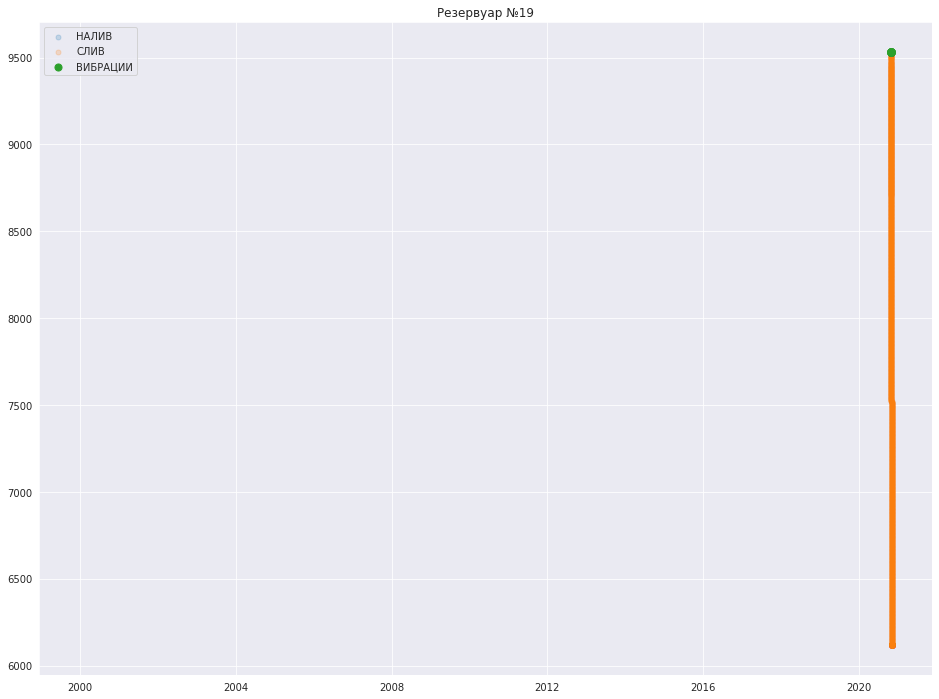

In [ ]:
#@title Результат НС
df['Type'] = -1 # не н
for i in df.Rez.unique():
  data = df[df.Rez==i]             # выбираем резервуар
  data['Type'] = predict_column(i) # маркируем уровни
  data = data[data.Type.notna()]   # удаляем не промаркированные
  # строим графики
  plt.figure(figsize=(16, 12))
  plt.title('Резервуар №'+str(i))
  for lbl, val in {'НАЛИВ': (1,25,0.2), 'СЛИВ': (0,25,0.2), 'ВИБРАЦИИ': (2,50,1)}.items():
    dataRez = data[data.Type==val[0]] # выбираем тип уровня
    plt.scatter(dataRez.Dt, dataRez.Lvl, label=lbl, s=val[1], alpha=val[2])
  plt.legend()
  plt.show()

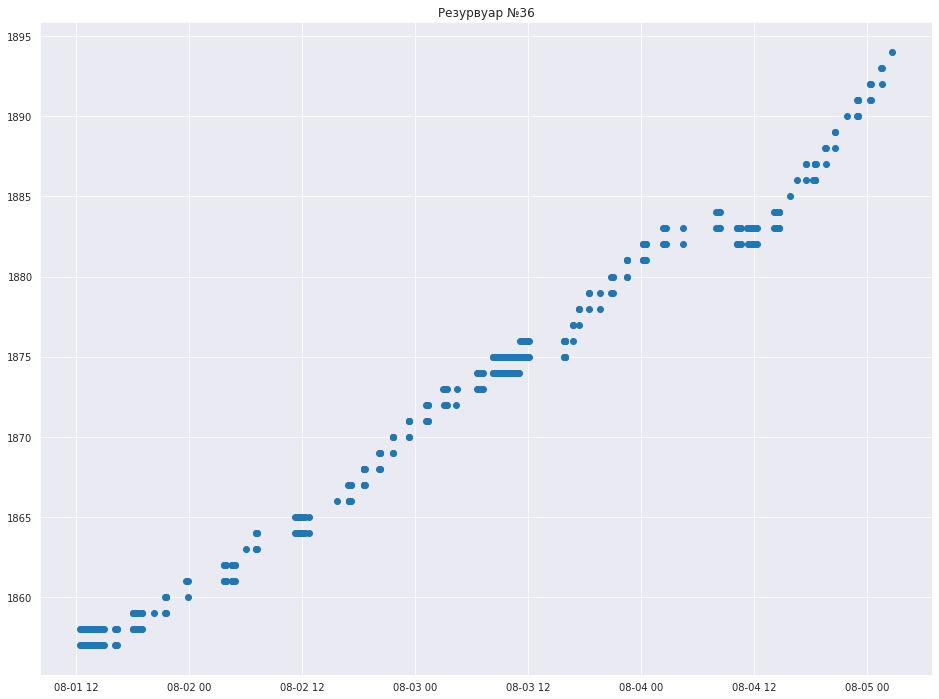

In [ ]:
for i in [36]:
  data = df[(df.Rez==i)][6300:6800]
  plt.figure(figsize=(16, 12))
  plt.title('Резурвуар №'+str(i))
  plt.scatter(data.Dt, data.Lvl)
  plt.show()

In [ ]:
#@title Результат НС
df['Type'] = -1 # не н
for i in df.Rez.unique():
  data = df[df.Rez==i]             # выбираем резервуар
  data['Type'] = predict_column(i) # маркируем уровни
  data = data[data.Type.notna()]   # удаляем не промаркированные
  # строим графики
  plt.figure(figsize=(16, 12))
  plt.title('Резервуар №'+str(i))
  for lbl, val in {'НАЛИВ': (1,25,0.2), 'СЛИВ': (0,25,0.2), 'ВИБРАЦИИ': (2,50,1)}.items():
    dataRez = data[data.Type==val[0]] # выбираем тип уровня
    plt.scatter(dataRez.Dt, dataRez.Lvl, label=lbl, s=val[1], alpha=val[2])
  plt.legend()
  plt.show()
df #обзор